# RATIO 2019 - Benchmarking Workshop

https://gluon-nlp.mxnet.io/install.html

```
pip install --upgrade 'mxnet>=1.3.0'
pip install gluonnlp
wget https://gluon-nlp.mxnet.io/_downloads/sentence_embedding.zip
unzip sentence_embedding.zip
ln -s sentence_embedding/bert bert
```

In [1]:
import datetime
import logging
import os
import random
import time
import warnings

import csv
import gluonnlp as nlp
import matplotlib.pyplot as plt
import mxnet as mx
import numpy as np
import pandas as pd
import seaborn as sns

from bert import *
from mxnet import gluon
from mxnet.gluon.data import Dataset, SimpleDataset
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score)
from sklearn.model_selection import train_test_split
from sklearn import utils
from tqdm import tqdm

In [2]:
warnings.filterwarnings('ignore')

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',
                    level=logging.INFO)

In [3]:
# set repeatable random state
np.random.seed(100)
random.seed(100)
mx.random.seed(10000)

In [4]:
# apply progress bars for pandas .apply() -> .progress_apply()
tqdm.pandas()

In [5]:
class Timer:
    def __init__(self, name=None):
        self.name = name

    def __enter__(self):
        self.time_start = time.time()

    def __exit__(self, *exc):
        time_end = time.time()
        time_delta = datetime.timedelta(seconds=(time_end - self.time_start))
        if self.name:
            print(("Time for [{}]: {}".format(self.name, time_delta)))
        else:
            print(("Time: {}".format(time_delta)))

# Task 1 - Same Side Classification

In [6]:
data_cross_path = 'data/same-side-classification/cross-topic/{}.csv'
data_within_path = 'data/same-side-classification/within-topic/{}.csv'

In [ ]:
%%bash
head -n 5 data/same-side-classification/cross-topic/training.csv

### Load within-topics and cross-topics data

In [7]:
# escapechar to detect quoting escapes, else it fails

# na_filter=False, because pandas automatic "nan" detection fails with the topic column, too
# cross_test_df['topic'].astype(str)[9270]

# within has "is_same_side" as string (boolean after latest update)
# cross has "is_same_side" as boolean (auto cast?)

with Timer("read cross"):
    # cross_traindev_df = pd.read_csv(data_cross_path.format('training'), index_col='id', escapechar='\\', na_filter=False)
    # cross_test_df = pd.read_csv(data_cross_path.format('test'), index_col='id', escapechar='\\', na_filter=False)
    cross_traindev_df = pd.read_csv(data_cross_path.format('training'),
                                    quotechar='"',
                                    quoting=csv.QUOTE_ALL,
                                    encoding='utf-8',
                                    escapechar='\\',
                                    doublequote=False,
                                    index_col='id')
    cross_test_df = pd.read_csv(data_cross_path.format('test'),
                                quotechar='"',
                                quoting=csv.QUOTE_ALL,
                                encoding='utf-8',
                                escapechar='\\',
                                doublequote=False,
                                index_col='id')

with Timer("read within"):
    # within_traindev_df = pd.read_csv(data_within_path.format('training'), index_col='id', escapechar='\\', na_filter=False)
    # within_test_df = pd.read_csv(data_within_path.format('test'), index_col='id', escapechar='\\', na_filter=False)
    within_traindev_df = pd.read_csv(data_within_path.format('training'),
                                     quotechar='"',
                                     quoting=csv.QUOTE_ALL,
                                     encoding='utf-8',
                                     escapechar='\\',
                                     doublequote=False,
                                     index_col='id')
    within_test_df = pd.read_csv(data_within_path.format('test'),
                                 quotechar='"',
                                 quoting=csv.QUOTE_ALL,
                                 encoding='utf-8',
                                 escapechar='\\',
                                 doublequote=False,
                                 index_col='id')

Time for [read cross]: 0:00:01.060900
Time for [read within]: 0:00:01.126363


In [8]:
# Adding a tag for the topics in focus: "gay marriage" and "abortion"
def add_tag(row):
    title = row['topic'].lower().strip()
    if "abortion" in title:
        row['tag'] = 'abortion'
    elif "gay marriage"  in title:
        row['tag'] = 'gay marriage'
    else:
        row['tag'] = 'NA'
    return row


with Timer("tag cross traindev"):
    cross_traindev_df = cross_traindev_df.apply(add_tag, axis=1)
with Timer("tag cross test"):
    cross_test_df = cross_test_df.apply(add_tag, axis=1)

with Timer("tag within traindev"):
    within_traindev_df = within_traindev_df.apply(add_tag, axis=1)
with Timer("tag within test"):
    within_test_df = within_test_df.apply(add_tag, axis=1)

Time for [tag cross traindev]: 0:00:35.993607
Time for [tag cross test]: 0:00:20.953618
Time for [tag within traindev]: 0:00:38.167500
Time for [tag within test]: 0:00:18.502694


### Get an overview about each dataset

In [33]:
# requires nltk  wordtokenize
# from nltk.tokenize import sent_tokenize, word_tokenize
# model uses BERT Tokenizer ...

def get_overview(df, task='same-side', class_name='is_same_side'):
    # Total instance numbers
    total = len(df)
    print("Task: ", task)
    print('=' * 40, '\n')

    print('Total instances: ', total)
    print('\n')

    print('For each topic:')
    for tag, tag_df in df.groupby(['tag']):
        print(tag, ': ', len(tag_df), ' instances')
        if class_name in df.columns:
            for is_same_side, side_df in tag_df.groupby([class_name]):
                print('\t\t', is_same_side, ': ', len(side_df), ' instances')
    print('\n')

    if class_name in df.columns:
        print('For each class value:')
        for class_value, class_df in df.groupby([class_name]):
            print(class_value, ': ', len(class_df), ' instances')
        print('\n')

    print('Unique argument1:', len(df['argument1'].unique()))
    print('Unique argument2:', len(df['argument2'].unique()))
    arguments = df['argument1'].values
    arguments = np.concatenate([arguments, df['argument2'].values])

    print('Unique total arguments:', len(set(list(arguments))), '\n')
    
    return

    print('-' * 40, '\n')

    arguments_length_lst = [
        len(word_tokenize(x)) for x in df['argument1'].values
    ]
    arguments_length_lst.extend(
        [len(word_tokenize(x)) for x in df['argument2'].values])
    print('Words:')
    print('\tshortest argument:', min(arguments_length_lst), ' words')
    print('\tlongest argument:', max(arguments_length_lst), ' words')
    print('\targument average length:', np.mean(arguments_length_lst),
          ' words')

    arguments_sent_length_lst = [
        len(sent_tokenize(x)) for x in df['argument1'].values
    ]
    arguments_sent_length_lst.extend(
        [len(sent_tokenize(x)) for x in df['argument2'].values])
    print('Sentences:')
    print('\tshortest argument:', min(arguments_sent_length_lst), ' sentences')
    print('\tlongest argument:', max(arguments_sent_length_lst), ' sentences')
    print('\targument average length:', np.mean(arguments_sent_length_lst),
          ' sentences')

In [34]:
with Timer("overview cross"):
    get_overview(cross_traindev_df)

Task:  same-side

Total instances:  61048


For each topic:
abortion :  61048  instances
		 False :  29853  instances
		 True :  31195  instances


For each class value:
False :  29853  instances
True :  31195  instances


Unique argument1: 7828
Unique argument2: 7806
Unique total arguments: 9361 

Time for [overview cross]: 0:00:00.317880


In [35]:
with Timer("overview within"):
    get_overview(within_traindev_df)

Task:  same-side

Total instances:  63903


For each topic:
abortion :  40840  instances
		 False :  20006  instances
		 True :  20834  instances
gay marriage :  23063  instances
		 False :  9786  instances
		 True :  13277  instances


For each class value:
False :  29792  instances
True :  34111  instances


Unique argument1: 10508
Unique argument2: 10453
Unique total arguments: 13574 

Time for [overview within]: 0:00:00.232440


##### Count raw length

In [36]:
def compute_arg_len(row):
    row['argument1_len'] = len(row['argument1'])
    row['argument2_len'] = len(row['argument2'])
    row['argument12_len_diff'] = row['argument1_len'] - row['argument2_len']
    return row


cross_traindev_df = cross_traindev_df.apply(compute_arg_len, axis=1)
within_traindev_df = within_traindev_df.apply(compute_arg_len, axis=1)
cross_test_df = cross_test_df.apply(compute_arg_len, axis=1)
within_test_df = within_test_df.apply(compute_arg_len, axis=1)

In [37]:
cross_traindev_df.describe()

,argument1_len,argument2_len,argument12_len_diff
count,61048.000000,61048.000000,61048.000000
mean,1182.739091,1020.121953,162.617137
std,1941.477713,1792.400250,1717.589016
min,6.000000,13.000000,-12785.000000
25%,75.000000,75.000000,-249.000000
50%,363.000000,338.000000,8.000000
75%,1160.000000,874.000000,402.000000
max,13320.000000,13320.000000,13179.000000


In [38]:
within_traindev_df.describe()

,argument1_len,argument2_len,argument12_len_diff
count,63903.000000,63903.000000,63903.000000
mean,1139.456332,990.760309,148.696024
std,1906.542592,1761.802828,1673.249280
min,6.000000,13.000000,-12785.000000
25%,68.000000,66.000000,-266.000000
50%,391.000000,346.000000,7.000000
75%,1023.000000,826.000000,421.000000
max,13260.000000,13320.000000,13156.000000


##### Tokenize and count tokens

In [39]:
ctx = mx.cpu()
_, vocabulary = nlp.model.get_model('bert_12_768_12',
                                    dataset_name='book_corpus_wiki_en_uncased',
                                    pretrained=True, ctx=ctx, use_pooler=True,
                                    use_decoder=False, use_classifier=False)
bert_tokenizer = nlp.data.BERTTokenizer(vocabulary, lower=True)
tokenizer = bert_tokenizer

In [40]:
from nltk.tokenize import sent_tokenize, word_tokenize
# nltk.download('punct')


# tokenizer from BERT
def tokenize_arguments(row):
    # tokenize
    row['argument1_tokens'] = tokenizer(row['argument1'])
    row['argument2_tokens'] = tokenizer(row['argument2'])

    # count tokens
    row['argument1_len'] = len(row['argument1_tokens'])
    row['argument2_len'] = len(row['argument2_tokens'])
    # token number diff
    row['argument12_len_diff'] = row['argument1_len'] - row['argument2_len']
    return row


cross_traindev_df = cross_traindev_df.apply(tokenize_arguments, axis=1)
within_traindev_df = within_traindev_df.apply(tokenize_arguments, axis=1)
cross_test_df = cross_test_df.apply(tokenize_arguments, axis=1)
within_test_df = within_test_df.apply(tokenize_arguments, axis=1)

In [41]:
cross_traindev_df.describe()

,argument1_len,argument2_len,argument12_len_diff
count,61048.000000,61048.000000,61048.000000
mean,264.863337,228.493382,36.369955
std,438.187823,405.800206,388.217671
min,3.000000,4.000000,-2837.000000
25%,18.000000,17.000000,-55.000000
50%,83.000000,72.000000,3.000000
75%,258.000000,197.000000,88.000000
max,2964.000000,2964.000000,2926.000000


In [42]:
within_traindev_df.describe()

,argument1_len,argument2_len,argument12_len_diff
count,63903.000000,63903.000000,63903.000000
mean,252.189647,219.179303,33.010344
std,425.471105,393.925258,373.091463
min,3.000000,4.000000,-2837.000000
25%,15.000000,14.000000,-58.000000
50%,85.000000,73.000000,2.000000
75%,222.000000,179.000000,91.000000
max,2825.000000,2964.000000,2724.000000


## Train model - Baseline

### train dev set - 70% 30%

In [15]:
def get_train_test_sets(df, ratio=0.30, random_state=1):
    X = df[['argument1', 'argument2', 'argument1_id', 'argument2_id', 'topic']]
    y = df[['is_same_side']]

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=ratio,
                                                        random_state=random_state,
                                                        shuffle=True)
    return X_train, X_test, y_train, y_test

### BERT

- https://gluon-nlp.mxnet.io/examples/sentence_embedding/bert.html

In [16]:
class MyBERTDataset(SimpleDataset):
    def __init__(self, X, y=None):
        self._X = X
        self._y = y
        super(MyBERTDataset, self).__init__(self._convert())
    
    def _convert(self):
        allsamples = list()

        if self._y is not None:
            df = self._X.merge(self._y, left_index=True, right_index=True)
            for _, row in df.iterrows():
                allsamples.append([row['argument1'], row['argument2'], "1" if str(row['is_same_side']) == "True" else "0"])
        else:
            for _, row in self._X.iterrows():
                allsamples.append([row['argument1'], row['argument2'], None])
        
        return allsamples

    # for lazy retrieval?
    #
    # def __getitem__(self, idx):
    #     row_X = self._X.iloc[idx]
    #     row_y = self._y.iloc[idx]
    #     return [row_X['argument1'], row_X['argument2'], "1" if row_y['is_same_side'] else "0"]
    #
    # def __len__(self):
    #     return len(self._X)

In [17]:
# df = X_dev.merge(y_dev, left_index=True, right_index=True)
# allsamples = list()
# for _, row in df.iterrows():
#     allsamples.append("1" if row['is_same_side'] == "True" else "0")
# np.unique(allsamples)

**TODO**: my own `BERTDatasetTransform` for extracting chunks from arguments or last part etc.

```python
transform = dataset.BERTDatasetTransform(bert_tokenizer, 512,
                                         labels=['0', '1'],
                                         label_dtype='int32',
                                         pad=True,
                                         pair=True)
```

http://localhost:9001/edit/bert/dataset.py @454
```python
# substitute with my own (e. g. last part, many parts etc.)
def __init__(...):
    self._bert_xform = BERTSentenceTransform(tokenizer, max_seq_length, pad=pad, pair=pair)
```
https://gluon-nlp.mxnet.io/master/_modules/gluonnlp/data/transforms.html#BERTSentenceTransform
```python
# substitute with my own (e. g. only last part (trim from start))
self._truncate_seq_pair(tokens_a, tokens_b, self._max_seq_length - 3)
```

https://mxnet.incubator.apache.org/_modules/mxnet/gluon/data/dataset.html#Dataset.transform

In [29]:
from mxnet.gluon import Block
from mxnet.gluon import nn


class BERTAdversarialClassifier(Block):
    """Model for sentence (pair) classification task with BERT.

    The model feeds token ids and token type ids into BERT to get the
    pooled BERT sequence representation, then apply a Dense layer for
    classification. Does this also for an adversarial classifier.

    Parameters
    ----------
    bert: BERTModel
        Bidirectional encoder with transformer.
    num_classes : int, default is 2
        The number of target classes.
    num_classes_adv : int, default is 2
        The number of target classes for adversarial classifier.
    dropout : float or None, default 0.0.
        Dropout probability for the bert output.
    prefix : str or None
        See document of `mx.gluon.Block`.
    params : ParameterDict or None
        See document of `mx.gluon.Block`.
    """

    def __init__(self,
                 bert,
                 num_classes=2,
                 num_classes_adv=2,
                 dropout=0.0,
                 prefix=None,
                 params=None):
        super(BERTClassifier, self).__init__(prefix=prefix, params=params)
        self.bert = bert
        with self.name_scope():
            self.classifier = nn.HybridSequential(prefix=prefix)
            if dropout:
                self.classifier.add(nn.Dropout(rate=dropout))
            self.classifier.add(nn.Dense(units=num_classes))

            self.adversarial_classifier = nn.HybridSequential(prefix=prefix)
            if dropout:
                self.adversarial_classifier.add(nn.Dropout(rate=dropout))
            self.adversarial_classifier.add(nn.Dense(units=num_classes_adv))

    def forward(self, inputs, token_types, valid_length=None):  # pylint: disable=arguments-differ
        """Generate the unnormalized scores for the given the input sequences.
        From both classifiers (classifier + adversarial_classifier).

        Parameters
        ----------
        inputs : NDArray, shape (batch_size, seq_length)
            Input words for the sequences.
        token_types : NDArray, shape (batch_size, seq_length)
            Token types for the sequences, used to indicate whether the word belongs to the
            first sentence or the second one.
        valid_length : NDArray or None, shape (batch_size)
            Valid length of the sequence. This is used to mask the padded tokens.

        Returns
        -------
        outputs : NDArray
            Shape (batch_size, num_classes), outputs of classifier.
        outputs_adv : NDArray
            Shape (batch_size, num_classes_adv), outputs of adversarial classifier.
        """
        _, pooler_out = self.bert(inputs, token_types, valid_length)
        classifier_out = self.classifier(pooler_out)
        adversarial_classifier_out = self.adversarial_classifier(pooler_out)
        return (classifier_out, adversarial_classifier_out)

In [30]:
# for chunked arguments, we may have to compute it all at once beforehand, should not be that much
# since we call with any `*BERTSentenceTransform` object, 
#    splitting the lines may have to be done before a transformation of a line?
#    -> chunking / sentence splitting, then feeding the result into the transformer, ...
from mxnet.gluon.data import Dataset, SimpleDataset


class MySimpleDataset(SimpleDataset):
    """Simple Dataset wrapper for lists and arrays.

    Parameters
    ----------
    data : dataset-like object
        Any object that implements `len()` and `[]`.
    """
    def __init__(self, data):
        self._data = data

    def __len__(self):
        return len(self._data)

    def __getitem__(self, idx):
        return self._data[idx]
    
    def transform(self, fn, lazy=True):
        """Returns a new dataset with each sample transformed by the
        transformer function `fn`.

        Parameters
        ----------
        fn : callable
            A transformer function that takes a sample as input and
            returns the transformed sample.
        lazy : bool, default True
            If False, transforms all samples at once. Otherwise,
            transforms each sample on demand. Note that if `fn`
            is stochastic, you must set lazy to True or you will
            get the same result on all epochs.

        Returns
        -------
        Dataset
            The transformed dataset.
        """
        trans = _LazyTransformDataset(self, fn)
        if lazy:
            return trans
        return SimpleDataset([i for i in trans])


class _LazyTransformDataset(Dataset):
    """Lazily transformed dataset."""
    def __init__(self, data, fn):
        self._data = data
        self._fn = fn

    def __len__(self):
        return len(self._data)

    def __getitem__(self, idx):
        item = self._data[idx]
        if isinstance(item, tuple):
            return self._fn(*item)
        return self._fn(item)

In [31]:
from gluonnlp.data import BERTSentenceTransform


class LastPartBERTSentenceTransform(BERTSentenceTransform):
    def __init__(self, tokenizer, max_seq_length, pad=True, pair=True):
        super(MyBERTSentenceTransform, self).__init__(tokenizer, max_seq_length, pad=pad, pair=pair)


    def _truncate_seq_pair(self, tokens_a, tokens_b, max_length):
        """Truncates a sequence pair in place to the maximum length.
        Removes from end of token list."""
        # This is a simple heuristic which will always truncate the longer sequence
        # one token at a time. This makes more sense than truncating an equal percent
        # of tokens from each, since if one sequence is very short then each token
        # that's truncated likely contains more information than a longer sequence.
        while True:
            total_length = len(tokens_a) + len(tokens_b)
            if total_length <= max_length:
                break
            if len(tokens_a) > len(tokens_b):
                tokens_a.pop(0)
            else:
                tokens_b.pop(0)


# TODO: random trim ? --> bad probably
# TODO: segment-wise, e. g. 0 for normal, 1 for tokens after normal tokens, ...

In [32]:
class LastPartBERTDatasetTransform(dataset.BERTDatasetTransform):
    def __init__(self, tokenizer, max_seq_length, labels=None, pad=True, pair=True, label_dtype='float32'):
        super(MyBERTDatasetTransform, self).__init__(tokenizer, max_seq_length, labels=labels, pad=pad, pair=pair, label_dtype=label_dtype)
        self._bert_xform = LastPartBERTSentenceTransform(tokenizer, max_seq_length, pad=pad, pair=pair)

In [18]:
def setup_bert():
    # change `ctx` to `mx.cpu()` if no GPU is available.
    ctx = mx.gpu(0)
    # ctx =  mx.gpu() if mx.context.num_gpus() else mx.cpu()
    # ctx = mx.cpu()
    
    bert_base, vocabulary = nlp.model.get_model('bert_12_768_12',
                                                 dataset_name='book_corpus_wiki_en_uncased',
                                                 pretrained=True, ctx=ctx, use_pooler=True,
                                                 use_decoder=False, use_classifier=False)
    print(bert_base)
    
    model = bert.BERTClassifier(bert_base, num_classes=2, dropout=0.1)
    # only need to initialize the classifier layer.
    model.classifier.initialize(init=mx.init.Normal(0.02), ctx=ctx)
    model.hybridize(static_alloc=True)

    # softmax cross entropy loss for classification
    loss_function = gluon.loss.SoftmaxCELoss()
    loss_function.hybridize(static_alloc=True)

    metric = mx.metric.Accuracy()
    
    # use the vocabulary from pre-trained model for tokenization
    bert_tokenizer = nlp.data.BERTTokenizer(vocabulary, lower=True)
    # maximum sequence length
    # max_len = 128  # + batch_size: 32
    max_len = 512  # + batch_size: 6 ?
    # the labels for the two classes
    all_labels = ["0", "1"]
    # whether to transform the data as sentence pairs.
    # for single sentence classification, set pair=False
    pair = True
    transform = dataset.BERTDatasetTransform(bert_tokenizer, max_len,
                                             labels=all_labels,
                                             label_dtype='int32',
                                             pad=True,
                                             pair=pair)

    return model, vocabulary, ctx, bert_tokenizer, transform, loss_function, metric, all_labels

In [19]:
def transform_dataset(X, y, transform):
    data_train_raw = MyBERTDataset(X, y)
    data_train = data_train_raw.transform(transform)
    return data_train_raw, data_train


def predict_out_to_ys(all_predictions, all_labels):
    y_true, y_pred = list(), list()
    
    for _, y_true_many, y_pred_many in all_predictions:
        y_true_many = y_true_many.T[0].asnumpy()
        # https://mxnet.incubator.apache.org/api/python/gluon/loss.html#mxnet.gluon.loss.SoftmaxCrossEntropyLoss
        # pred: the prediction tensor, where the batch_axis dimension ranges over batch size and axis dimension ranges over the number of classes.
        y_pred_many = np.argmax(y_pred_many, axis=1).asnumpy()

        y_true.extend(list(y_true_many))
        y_pred.extend(list(y_pred_many))
        # TODO: convert label_id to label?
        # y_pred.extend(all_labels[c] for c in list(y_pred_many))
        
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    return y_true, y_pred

In [20]:
def train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=3, checkpoint_dir="data", use_checkpoints=True):
    with Timer("setup training"):
        train_sampler = nlp.data.FixedBucketSampler(
            lengths=[int(item[1]) for item in tqdm(data_train)],
            batch_size=batch_size,
            shuffle=True)
        bert_dataloader = mx.gluon.data.DataLoader(data_train,
                                                   batch_sampler=train_sampler)

        trainer = gluon.Trainer(model.collect_params(), 'adam', {
            'learning_rate': lr,
            'epsilon': 1e-9
        })

        # collect all differentiable parameters
        # grad_req == 'null' indicates no gradients are calculated (e.g. constant parameters)
        # the gradients for these params are clipped later
        params = [p for p in model.collect_params().values() if p.grad_req != 'null']

    log_interval = 10
    with Timer("training"):
        stats = list()
        for epoch_id in range(num_epochs):
            if use_checkpoints:
                epoch_checkpoint_savefile = "bert.model.checkpoint{}.params".format(epoch_id)
                if checkpoint_dir is not None:
                    epoch_checkpoint_savefile = os.path.join(checkpoint_dir, epoch_checkpoint_savefile)
                if os.path.exists(epoch_checkpoint_savefile):
                    model.load_parameters(epoch_checkpoint_savefile, ctx=ctx)
                    print("loaded checkpoint for epoch {}".format(epoch_id))
                    continue

            with Timer("epoch {}".format(epoch_id)):
                metric.reset()
                step_loss = 0
                t_p = time.time()  # time keeping
                for batch_id, (token_ids, valid_length, segment_ids,
                               label) in enumerate(bert_dataloader):
                    with mx.autograd.record():

                        # load data to GPU
                        token_ids = token_ids.as_in_context(ctx)
                        valid_length = valid_length.as_in_context(ctx)
                        segment_ids = segment_ids.as_in_context(ctx)
                        label = label.as_in_context(ctx)

                        # forward computation
                        out = model(token_ids, segment_ids,
                                    valid_length.astype('float32'))
                        ls = loss_function(out, label).mean()

                    # backward computation
                    ls.backward()

                    # gradient clipping
                    trainer.allreduce_grads()
                    nlp.utils.clip_grad_global_norm(params, 1)
                    trainer.update(1)

                    step_loss += ls.asscalar()
                    metric.update([label], [out])
                    stats.append((metric.get()[1], ls.asscalar()))
                    if (batch_id + 1) % (log_interval) == 0:
                        print(
                            '[Epoch {} Batch {}/{}] loss={:.4f}, lr={:.7f}, acc={:.3f} - time {}'
                            .format(epoch_id, batch_id + 1, len(bert_dataloader),
                                    step_loss / log_interval, trainer.learning_rate,
                                    metric.get()[1],
                                    datetime.timedelta(seconds=(time.time() - t_p))))
                        t_p = time.time()
                        step_loss = 0

            if use_checkpoints:
                model.save_parameters(epoch_checkpoint_savefile)
            
    return stats

In [21]:
def predict(model, data_predict, ctx, metric, loss_function, batch_size=32):
    bert_dataloader = mx.gluon.data.DataLoader(data_predict, batch_size=batch_size)
    
    all_predictions = list()

    with Timer("prediction"):
        metric.reset()
        cum_loss = 0
        for batch_id, (token_ids, valid_length, segment_ids,
                       label) in enumerate(tqdm(bert_dataloader)):
            # load data to GPU
            token_ids = token_ids.as_in_context(ctx)
            valid_length = valid_length.as_in_context(ctx)
            segment_ids = segment_ids.as_in_context(ctx)
            label = label.as_in_context(ctx)

            # forward computation
            out = model(token_ids, segment_ids,
                        valid_length.astype('float32'))
            ls = loss_function(out, label).mean()

            metric.update([label], [out])
            cum_loss += ls.asscalar()  # .sum() ?
            all_predictions.append((batch_id, label, out))
            
    return all_predictions, cum_loss

In [22]:
def print_infos(vocabulary, data_train_raw, data_train):
    sample_id = 0

    # sentence a
    print(data_train_raw[sample_id][0])
    # sentence b
    print(data_train_raw[sample_id][1])
    # 1 means equivalent, 0 means not equivalent
    print(data_train_raw[sample_id][2])

    print('vocabulary used for tokenization = \n%s'%vocabulary)
    print('[PAD] token id = %s'%(vocabulary['[PAD]']))
    print('[CLS] token id = %s'%(vocabulary['[CLS]']))
    print('[SEP] token id = %s'%(vocabulary['[SEP]']))

    print('token ids = \n%s'%data_train[sample_id][0])
    print('valid length = \n%s'%data_train[sample_id][1])
    print('segment ids = \n%s'%data_train[sample_id][2])
    print('label = \n%s'%data_train[sample_id][3])
    

def plot_train_stats(stats):
    if not stats:
        print("no stats to plot")
        return

    x = np.arange(len(stats))  # arange/linspace

    acc_dots, loss_dots = zip(*stats)

    plt.subplot(2, 1, 1)
    plt.plot(x, acc_dots)  # Linie: '-', 'o-', '.-'
    plt.title('Training BERTClassifier')
    plt.ylabel('Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(x, loss_dots)
    plt.xlabel('Batches')
    plt.ylabel('Loss')

    plt.show()

### Evaluate

In [23]:
def heatconmat(y_test, y_pred):
    sns.set_context('talk')
    plt.figure(figsize=(9, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True,
                fmt='d',
                cbar=False,
                cmap='gist_earth_r',
                yticklabels=sorted(np.unique(y_test)))
    plt.show()


def report_training_results(y_test, y_pred, name=None, heatmap=True):
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))
    if heatmap:
        heatconmat(y_test, y_pred)
    print()
    print('Accuracy: ', round(accuracy_score(y_test, y_pred), 2), '\n')  #

    print('Report{}:'.format("" if not name else " for [{}]".format(name)))
    print(classification_report(y_test, y_pred))

    f1_dic = {}
    f1_dic['macro'] = round(
        f1_score(y_pred=y_pred, y_true=y_test, average='macro'), 2)
    f1_dic['micro'] = round(
        f1_score(y_pred=y_pred, y_true=y_test, average='micro'), 2)
    return f1_dic

### Within topic - Training and evaluating model 

In [24]:
# 1. Getting train and dev data
with Timer("1 - test/train split"):
    X_train, X_dev, y_train, y_dev = get_train_test_sets(within_traindev_df)

Time for [1 - test/train split]: 0:00:00.013065


In [25]:
# 2. setup
with Timer("2 - setup BERT model"):
    model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert()

BERTModel(
  (encoder): BERTEncoder(
    (dropout_layer): Dropout(p = 0.1, axes=())
    (layer_norm): BERTLayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
    (transformer_cells): HybridSequential(
      (0): BERTEncoderCell(
        (dropout_layer): Dropout(p = 0.1, axes=())
        (attention_cell): MultiHeadAttentionCell(
          (_base_cell): DotProductAttentionCell(
            (_dropout_layer): Dropout(p = 0.1, axes=())
          )
          (proj_query): Dense(768 -> 768, linear)
          (proj_key): Dense(768 -> 768, linear)
          (proj_value): Dense(768 -> 768, linear)
        )
        (proj): Dense(768 -> 768, linear)
        (ffn): BERTPositionwiseFFN(
          (ffn_1): Dense(768 -> 3072, linear)
          (activation): GELU()
          (ffn_2): Dense(3072 -> 768, linear)
          (dropout_layer): Dropout(p = 0.1, axes=())
          (layer_norm): BERTLayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
        )
        (la

In [26]:
with Timer("3 - prepare training data"):
    data_train_raw, data_train = transform_dataset(X_train, y_train, transform)
    print_infos(vocabulary, data_train_raw, data_train)

wanted fetuses are beloved "babies"; unwanted ones are "tissue" (inconsistent)
abortions are emotionally and psychologically unsafe.
1
vocabulary used for tokenization = 
Vocab(size=30522, unk="[UNK]", reserved="['[PAD]', '[CLS]', '[SEP]', '[MASK]']")
[PAD] token id = 1
[CLS] token id = 2
[SEP] token id = 3
token ids = 
[    2  2359 10768  5809  2229  2024 11419  1000 10834  1000  1025 18162
  3924  2024  1000  8153  1000  1006 20316  1007     3 11324  2015  2024
 14868  1998  8317  2135 25135  1012     3     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1   

In [ ]:
with Timer("4 - train model"):
    # train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=3)
    stats = train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=2)
    # model.save_parameters("data/same-side-classification/within-topic/bert.model.params")
    model.save_parameters("data/bert.model.params")

    plot_train_stats(stats)

In [27]:
with Timer("5 - prepare eval data"):
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
    print_infos(vocabulary, data_dev_raw, data_dev)

abortion opens the door to the sexual exploitation of women the existence of abortion gives men a little more of a safeguard against unintentionally impregnating a woman. as a result, men will be more aggressive in their sexual exploitation of women.
the fact that a child is likely to have a short life does not justify further shortening it:
0
vocabulary used for tokenization = 
Vocab(size=30522, unk="[UNK]", reserved="['[PAD]', '[CLS]', '[SEP]', '[MASK]']")
[PAD] token id = 1
[CLS] token id = 2
[SEP] token id = 3
token ids = 
[    2 11324  7480  1996  2341  2000  1996  4424 14427  1997  2308  1996
  4598  1997 11324  3957  2273  1037  2210  2062  1997  1037 28805  2114
  4895 18447  4765 19301  2135 17727  2890 16989  3436  1037  2450  1012
  2004  1037  2765  1010  2273  2097  2022  2062  9376  1999  2037  4424
 14427  1997  2308  1012     3  1996  2755  2008  1037  2775  2003  3497
  2000  2031  1037  2460  2166  2515  2025 16114  2582  2460  7406  2009
  1024     3     1     1     

In [ ]:
with Timer("6 - evaluate"):
    # model.load_parameters("data/same-side-classification/within-topic/bert.model.params", ctx=ctx)
    model.load_parameters("data/bert.model.params", ctx=ctx)
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function)
    print("Accuracy:", metric.get()[1])

    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name="BERTClassifier", heatmap=False)

### Train and evaluate each epoch

100%|██████████| 44732/44732 [03:49<00:00, 195.13it/s]


Time for [setup training]: 0:03:49.266442
[Epoch 0 Batch 10/7459] loss=0.6956, lr=0.0000050, acc=0.500 - time 0:00:09.210284
[Epoch 0 Batch 20/7459] loss=0.7045, lr=0.0000050, acc=0.500 - time 0:00:08.689273
[Epoch 0 Batch 30/7459] loss=0.7016, lr=0.0000050, acc=0.511 - time 0:00:08.945445
[Epoch 0 Batch 40/7459] loss=0.7035, lr=0.0000050, acc=0.496 - time 0:00:09.341060
[Epoch 0 Batch 50/7459] loss=0.7095, lr=0.0000050, acc=0.498 - time 0:00:08.861499
[Epoch 0 Batch 60/7459] loss=0.6998, lr=0.0000050, acc=0.501 - time 0:00:08.863514
[Epoch 0 Batch 70/7459] loss=0.7179, lr=0.0000050, acc=0.492 - time 0:00:09.254076
[Epoch 0 Batch 80/7459] loss=0.6835, lr=0.0000050, acc=0.505 - time 0:00:08.997881
[Epoch 0 Batch 90/7459] loss=0.7015, lr=0.0000050, acc=0.501 - time 0:00:08.912734
[Epoch 0 Batch 100/7459] loss=0.6716, lr=0.0000050, acc=0.509 - time 0:00:09.014593
[Epoch 0 Batch 110/7459] loss=0.6754, lr=0.0000050, acc=0.519 - time 0:00:09.051070
[Epoch 0 Batch 120/7459] loss=0.6768, lr=0.

[Epoch 0 Batch 990/7459] loss=0.7964, lr=0.0000050, acc=0.588 - time 0:00:09.158704
[Epoch 0 Batch 1000/7459] loss=0.7025, lr=0.0000050, acc=0.588 - time 0:00:08.853770
[Epoch 0 Batch 1010/7459] loss=0.6219, lr=0.0000050, acc=0.589 - time 0:00:09.134650
[Epoch 0 Batch 1020/7459] loss=0.5532, lr=0.0000050, acc=0.589 - time 0:00:09.396348
[Epoch 0 Batch 1030/7459] loss=0.6064, lr=0.0000050, acc=0.590 - time 0:00:09.503942
[Epoch 0 Batch 1040/7459] loss=0.5519, lr=0.0000050, acc=0.591 - time 0:00:08.805846
[Epoch 0 Batch 1050/7459] loss=0.6178, lr=0.0000050, acc=0.591 - time 0:00:09.005605
[Epoch 0 Batch 1060/7459] loss=0.6810, lr=0.0000050, acc=0.591 - time 0:00:08.961717
[Epoch 0 Batch 1070/7459] loss=0.6649, lr=0.0000050, acc=0.591 - time 0:00:09.223788
[Epoch 0 Batch 1080/7459] loss=0.5230, lr=0.0000050, acc=0.592 - time 0:00:08.848648
[Epoch 0 Batch 1090/7459] loss=0.6304, lr=0.0000050, acc=0.593 - time 0:00:08.958288
[Epoch 0 Batch 1100/7459] loss=0.6978, lr=0.0000050, acc=0.592 - t

[Epoch 0 Batch 1980/7459] loss=0.6039, lr=0.0000050, acc=0.635 - time 0:00:09.127337
[Epoch 0 Batch 1990/7459] loss=0.4038, lr=0.0000050, acc=0.636 - time 0:00:08.942529
[Epoch 0 Batch 2000/7459] loss=0.4801, lr=0.0000050, acc=0.637 - time 0:00:09.107023
[Epoch 0 Batch 2010/7459] loss=0.5174, lr=0.0000050, acc=0.637 - time 0:00:09.316684
[Epoch 0 Batch 2020/7459] loss=0.4986, lr=0.0000050, acc=0.638 - time 0:00:09.022306
[Epoch 0 Batch 2030/7459] loss=0.4254, lr=0.0000050, acc=0.639 - time 0:00:08.992911
[Epoch 0 Batch 2040/7459] loss=0.5940, lr=0.0000050, acc=0.639 - time 0:00:09.560171
[Epoch 0 Batch 2050/7459] loss=0.4802, lr=0.0000050, acc=0.639 - time 0:00:09.111974
[Epoch 0 Batch 2060/7459] loss=0.5380, lr=0.0000050, acc=0.640 - time 0:00:08.932723
[Epoch 0 Batch 2070/7459] loss=0.4955, lr=0.0000050, acc=0.640 - time 0:00:09.266306
[Epoch 0 Batch 2080/7459] loss=0.4429, lr=0.0000050, acc=0.641 - time 0:00:09.288569
[Epoch 0 Batch 2090/7459] loss=0.3830, lr=0.0000050, acc=0.642 - 

[Epoch 0 Batch 2950/7459] loss=0.3991, lr=0.0000050, acc=0.675 - time 0:00:09.153758
[Epoch 0 Batch 2960/7459] loss=0.2098, lr=0.0000050, acc=0.675 - time 0:00:09.033749
[Epoch 0 Batch 2970/7459] loss=0.5183, lr=0.0000050, acc=0.675 - time 0:00:08.840586
[Epoch 0 Batch 2980/7459] loss=0.4198, lr=0.0000050, acc=0.676 - time 0:00:09.017963
[Epoch 0 Batch 2990/7459] loss=0.4440, lr=0.0000050, acc=0.676 - time 0:00:09.283866
[Epoch 0 Batch 3000/7459] loss=0.5926, lr=0.0000050, acc=0.676 - time 0:00:09.133967
[Epoch 0 Batch 3010/7459] loss=0.4263, lr=0.0000050, acc=0.677 - time 0:00:08.860744
[Epoch 0 Batch 3020/7459] loss=0.4959, lr=0.0000050, acc=0.677 - time 0:00:08.964941
[Epoch 0 Batch 3030/7459] loss=0.4451, lr=0.0000050, acc=0.677 - time 0:00:09.195209
[Epoch 0 Batch 3040/7459] loss=0.6300, lr=0.0000050, acc=0.677 - time 0:00:09.237818
[Epoch 0 Batch 3050/7459] loss=0.5220, lr=0.0000050, acc=0.677 - time 0:00:08.849174
[Epoch 0 Batch 3060/7459] loss=0.3151, lr=0.0000050, acc=0.678 - 

[Epoch 0 Batch 3920/7459] loss=0.2960, lr=0.0000050, acc=0.694 - time 0:00:08.864856
[Epoch 0 Batch 3930/7459] loss=0.4206, lr=0.0000050, acc=0.695 - time 0:00:09.397017
[Epoch 0 Batch 3940/7459] loss=0.3501, lr=0.0000050, acc=0.695 - time 0:00:09.546611
[Epoch 0 Batch 3950/7459] loss=0.3263, lr=0.0000050, acc=0.695 - time 0:00:08.860977
[Epoch 0 Batch 3960/7459] loss=0.3465, lr=0.0000050, acc=0.695 - time 0:00:09.164261
[Epoch 0 Batch 3970/7459] loss=0.4134, lr=0.0000050, acc=0.695 - time 0:00:09.177642
[Epoch 0 Batch 3980/7459] loss=0.2973, lr=0.0000050, acc=0.696 - time 0:00:09.181561
[Epoch 0 Batch 3990/7459] loss=0.2662, lr=0.0000050, acc=0.696 - time 0:00:08.753381
[Epoch 0 Batch 4000/7459] loss=0.4243, lr=0.0000050, acc=0.697 - time 0:00:09.347552
[Epoch 0 Batch 4010/7459] loss=0.3476, lr=0.0000050, acc=0.697 - time 0:00:09.249707
[Epoch 0 Batch 4020/7459] loss=0.4767, lr=0.0000050, acc=0.697 - time 0:00:08.997790
[Epoch 0 Batch 4030/7459] loss=0.4364, lr=0.0000050, acc=0.697 - 

[Epoch 0 Batch 4890/7459] loss=0.2246, lr=0.0000050, acc=0.715 - time 0:00:09.262108
[Epoch 0 Batch 4900/7459] loss=0.2606, lr=0.0000050, acc=0.715 - time 0:00:08.815017
[Epoch 0 Batch 4910/7459] loss=0.3486, lr=0.0000050, acc=0.715 - time 0:00:09.099470
[Epoch 0 Batch 4920/7459] loss=0.1492, lr=0.0000050, acc=0.715 - time 0:00:09.042835
[Epoch 0 Batch 4930/7459] loss=0.1840, lr=0.0000050, acc=0.716 - time 0:00:09.184199
[Epoch 0 Batch 4940/7459] loss=0.3545, lr=0.0000050, acc=0.716 - time 0:00:09.033555
[Epoch 0 Batch 4950/7459] loss=0.4426, lr=0.0000050, acc=0.716 - time 0:00:09.178752
[Epoch 0 Batch 4960/7459] loss=0.1671, lr=0.0000050, acc=0.717 - time 0:00:09.008222
[Epoch 0 Batch 4970/7459] loss=0.6607, lr=0.0000050, acc=0.717 - time 0:00:09.325563
[Epoch 0 Batch 4980/7459] loss=0.2784, lr=0.0000050, acc=0.717 - time 0:00:08.838892
[Epoch 0 Batch 4990/7459] loss=0.4691, lr=0.0000050, acc=0.717 - time 0:00:09.046456
[Epoch 0 Batch 5000/7459] loss=0.4808, lr=0.0000050, acc=0.717 - 

[Epoch 0 Batch 5860/7459] loss=0.6751, lr=0.0000050, acc=0.732 - time 0:00:08.877284
[Epoch 0 Batch 5870/7459] loss=0.2591, lr=0.0000050, acc=0.733 - time 0:00:09.337049
[Epoch 0 Batch 5880/7459] loss=0.2723, lr=0.0000050, acc=0.733 - time 0:00:09.375006
[Epoch 0 Batch 5890/7459] loss=0.2777, lr=0.0000050, acc=0.733 - time 0:00:08.989931
[Epoch 0 Batch 5900/7459] loss=0.2191, lr=0.0000050, acc=0.733 - time 0:00:08.740877
[Epoch 0 Batch 5910/7459] loss=0.4038, lr=0.0000050, acc=0.733 - time 0:00:09.074534
[Epoch 0 Batch 5920/7459] loss=0.3335, lr=0.0000050, acc=0.734 - time 0:00:08.916733
[Epoch 0 Batch 5930/7459] loss=0.1020, lr=0.0000050, acc=0.734 - time 0:00:08.935178
[Epoch 0 Batch 5940/7459] loss=0.1910, lr=0.0000050, acc=0.734 - time 0:00:08.852354
[Epoch 0 Batch 5950/7459] loss=0.3349, lr=0.0000050, acc=0.734 - time 0:00:09.421390
[Epoch 0 Batch 5960/7459] loss=0.3104, lr=0.0000050, acc=0.734 - time 0:00:09.239448
[Epoch 0 Batch 5970/7459] loss=0.3444, lr=0.0000050, acc=0.735 - 

[Epoch 0 Batch 6830/7459] loss=0.3291, lr=0.0000050, acc=0.747 - time 0:00:09.213580
[Epoch 0 Batch 6840/7459] loss=0.1149, lr=0.0000050, acc=0.747 - time 0:00:08.741868
[Epoch 0 Batch 6850/7459] loss=0.3901, lr=0.0000050, acc=0.747 - time 0:00:09.309958
[Epoch 0 Batch 6860/7459] loss=0.2799, lr=0.0000050, acc=0.747 - time 0:00:09.023260
[Epoch 0 Batch 6870/7459] loss=0.2917, lr=0.0000050, acc=0.747 - time 0:00:08.840095
[Epoch 0 Batch 6880/7459] loss=0.4169, lr=0.0000050, acc=0.748 - time 0:00:09.453568
[Epoch 0 Batch 6890/7459] loss=0.5002, lr=0.0000050, acc=0.748 - time 0:00:09.290995
[Epoch 0 Batch 6900/7459] loss=0.4672, lr=0.0000050, acc=0.748 - time 0:00:09.214275
[Epoch 0 Batch 6910/7459] loss=0.4211, lr=0.0000050, acc=0.748 - time 0:00:09.133035
[Epoch 0 Batch 6920/7459] loss=0.2519, lr=0.0000050, acc=0.748 - time 0:00:09.099841
[Epoch 0 Batch 6930/7459] loss=0.2905, lr=0.0000050, acc=0.748 - time 0:00:08.993438
[Epoch 0 Batch 6940/7459] loss=0.4515, lr=0.0000050, acc=0.748 - 

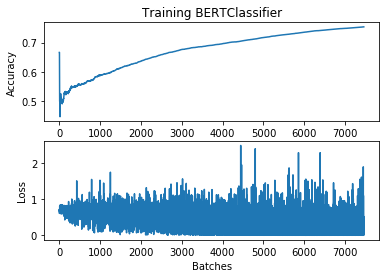

  0%|          | 0/3196 [00:00<?, ?it/s]

Time for [4 - train model - 0]: 1:57:10.003858


100%|██████████| 3196/3196 [11:30<00:00,  4.63it/s]


Time for [prediction]: 0:11:30.588622
Accuracy in epoch 0: 0.8343852694173491
Confusion Matrix:
[[8143  690]
 [2485 7853]]

Accuracy:  0.83 

Report for [BERTClassifier]:
              precision    recall  f1-score   support

           0       0.77      0.92      0.84      8833
           1       0.92      0.76      0.83     10338

    accuracy                           0.83     19171
   macro avg       0.84      0.84      0.83     19171
weighted avg       0.85      0.83      0.83     19171

Time for [6 - evaluate - 0]: 0:11:31.316118


100%|██████████| 44732/44732 [03:46<00:00, 197.88it/s]


Time for [setup training]: 0:03:46.083508
loaded checkpoint for epoch 0
[Epoch 1 Batch 10/7459] loss=0.2069, lr=0.0000050, acc=0.867 - time 0:00:09.148408
[Epoch 1 Batch 20/7459] loss=0.3309, lr=0.0000050, acc=0.858 - time 0:00:09.106220
[Epoch 1 Batch 30/7459] loss=0.3495, lr=0.0000050, acc=0.839 - time 0:00:08.790247
[Epoch 1 Batch 40/7459] loss=0.2955, lr=0.0000050, acc=0.842 - time 0:00:09.283306
[Epoch 1 Batch 50/7459] loss=0.1979, lr=0.0000050, acc=0.850 - time 0:00:09.034364
[Epoch 1 Batch 60/7459] loss=0.1306, lr=0.0000050, acc=0.864 - time 0:00:08.762041
[Epoch 1 Batch 70/7459] loss=0.0745, lr=0.0000050, acc=0.879 - time 0:00:08.893279
[Epoch 1 Batch 80/7459] loss=0.5711, lr=0.0000050, acc=0.860 - time 0:00:09.482027
[Epoch 1 Batch 90/7459] loss=0.4191, lr=0.0000050, acc=0.859 - time 0:00:09.139013
[Epoch 1 Batch 100/7459] loss=0.2681, lr=0.0000050, acc=0.867 - time 0:00:08.764740
[Epoch 1 Batch 110/7459] loss=0.3276, lr=0.0000050, acc=0.861 - time 0:00:09.181770
[Epoch 1 Batc

[Epoch 1 Batch 980/7459] loss=0.2900, lr=0.0000050, acc=0.826 - time 0:00:08.985941
[Epoch 1 Batch 990/7459] loss=0.1935, lr=0.0000050, acc=0.827 - time 0:00:08.798146
[Epoch 1 Batch 1000/7459] loss=0.2174, lr=0.0000050, acc=0.827 - time 0:00:09.185526
[Epoch 1 Batch 1010/7459] loss=0.3941, lr=0.0000050, acc=0.827 - time 0:00:09.449108
[Epoch 1 Batch 1020/7459] loss=0.1389, lr=0.0000050, acc=0.829 - time 0:00:08.748276
[Epoch 1 Batch 1030/7459] loss=0.2381, lr=0.0000050, acc=0.829 - time 0:00:08.940997
[Epoch 1 Batch 1040/7459] loss=0.2089, lr=0.0000050, acc=0.830 - time 0:00:09.292600
[Epoch 1 Batch 1050/7459] loss=0.2934, lr=0.0000050, acc=0.831 - time 0:00:08.960321
[Epoch 1 Batch 1060/7459] loss=0.3614, lr=0.0000050, acc=0.831 - time 0:00:08.882000
[Epoch 1 Batch 1070/7459] loss=0.2031, lr=0.0000050, acc=0.831 - time 0:00:09.060379
[Epoch 1 Batch 1080/7459] loss=0.3554, lr=0.0000050, acc=0.831 - time 0:00:09.430104
[Epoch 1 Batch 1090/7459] loss=0.1636, lr=0.0000050, acc=0.832 - ti

[Epoch 1 Batch 1950/7459] loss=0.3774, lr=0.0000050, acc=0.839 - time 0:00:09.275377
[Epoch 1 Batch 1960/7459] loss=0.4340, lr=0.0000050, acc=0.838 - time 0:00:09.503468
[Epoch 1 Batch 1970/7459] loss=0.2887, lr=0.0000050, acc=0.838 - time 0:00:09.268708
[Epoch 1 Batch 1980/7459] loss=0.1780, lr=0.0000050, acc=0.839 - time 0:00:08.721728
[Epoch 1 Batch 1990/7459] loss=0.1793, lr=0.0000050, acc=0.839 - time 0:00:09.193693
[Epoch 1 Batch 2000/7459] loss=0.1328, lr=0.0000050, acc=0.840 - time 0:00:08.994189
[Epoch 1 Batch 2010/7459] loss=0.2307, lr=0.0000050, acc=0.840 - time 0:00:08.899706
[Epoch 1 Batch 2020/7459] loss=0.3547, lr=0.0000050, acc=0.840 - time 0:00:09.202456
[Epoch 1 Batch 2030/7459] loss=0.2502, lr=0.0000050, acc=0.840 - time 0:00:09.106505
[Epoch 1 Batch 2040/7459] loss=0.3952, lr=0.0000050, acc=0.840 - time 0:00:09.239819
[Epoch 1 Batch 2050/7459] loss=0.3586, lr=0.0000050, acc=0.840 - time 0:00:09.126006
[Epoch 1 Batch 2060/7459] loss=0.2102, lr=0.0000050, acc=0.840 - 

[Epoch 1 Batch 2920/7459] loss=0.2041, lr=0.0000050, acc=0.842 - time 0:00:09.055860
[Epoch 1 Batch 2930/7459] loss=0.3597, lr=0.0000050, acc=0.842 - time 0:00:08.936496
[Epoch 1 Batch 2940/7459] loss=0.3315, lr=0.0000050, acc=0.842 - time 0:00:09.134437
[Epoch 1 Batch 2950/7459] loss=0.3414, lr=0.0000050, acc=0.842 - time 0:00:09.383233
[Epoch 1 Batch 2960/7459] loss=0.2958, lr=0.0000050, acc=0.842 - time 0:00:09.141148
[Epoch 1 Batch 2970/7459] loss=0.4016, lr=0.0000050, acc=0.841 - time 0:00:09.349236
[Epoch 1 Batch 2980/7459] loss=0.2784, lr=0.0000050, acc=0.841 - time 0:00:08.989220
[Epoch 1 Batch 2990/7459] loss=0.4560, lr=0.0000050, acc=0.841 - time 0:00:09.544255
[Epoch 1 Batch 3000/7459] loss=0.2354, lr=0.0000050, acc=0.841 - time 0:00:09.114870
[Epoch 1 Batch 3010/7459] loss=0.1885, lr=0.0000050, acc=0.842 - time 0:00:08.769557
[Epoch 1 Batch 3020/7459] loss=0.2034, lr=0.0000050, acc=0.842 - time 0:00:09.116423
[Epoch 1 Batch 3030/7459] loss=0.2989, lr=0.0000050, acc=0.842 - 

[Epoch 1 Batch 3890/7459] loss=0.2334, lr=0.0000050, acc=0.845 - time 0:00:08.899404
[Epoch 1 Batch 3900/7459] loss=0.2180, lr=0.0000050, acc=0.845 - time 0:00:09.092685
[Epoch 1 Batch 3910/7459] loss=0.4318, lr=0.0000050, acc=0.845 - time 0:00:09.371954
[Epoch 1 Batch 3920/7459] loss=0.1798, lr=0.0000050, acc=0.845 - time 0:00:08.881406
[Epoch 1 Batch 3930/7459] loss=0.3262, lr=0.0000050, acc=0.845 - time 0:00:08.969084
[Epoch 1 Batch 3940/7459] loss=0.4440, lr=0.0000050, acc=0.845 - time 0:00:09.405020
[Epoch 1 Batch 3950/7459] loss=0.3215, lr=0.0000050, acc=0.845 - time 0:00:09.003006
[Epoch 1 Batch 3960/7459] loss=0.3915, lr=0.0000050, acc=0.845 - time 0:00:08.980146
[Epoch 1 Batch 3970/7459] loss=0.2348, lr=0.0000050, acc=0.845 - time 0:00:08.936554
[Epoch 1 Batch 3980/7459] loss=0.4087, lr=0.0000050, acc=0.845 - time 0:00:09.494437
[Epoch 1 Batch 3990/7459] loss=0.3410, lr=0.0000050, acc=0.845 - time 0:00:09.235850
[Epoch 1 Batch 4000/7459] loss=0.2528, lr=0.0000050, acc=0.845 - 

[Epoch 1 Batch 4860/7459] loss=0.4865, lr=0.0000050, acc=0.848 - time 0:00:08.958916
[Epoch 1 Batch 4870/7459] loss=0.3168, lr=0.0000050, acc=0.848 - time 0:00:09.391948
[Epoch 1 Batch 4880/7459] loss=0.2738, lr=0.0000050, acc=0.849 - time 0:00:09.152090
[Epoch 1 Batch 4890/7459] loss=0.2710, lr=0.0000050, acc=0.849 - time 0:00:09.015636
[Epoch 1 Batch 4900/7459] loss=0.1686, lr=0.0000050, acc=0.849 - time 0:00:09.163583
[Epoch 1 Batch 4910/7459] loss=0.0353, lr=0.0000050, acc=0.849 - time 0:00:08.894478
[Epoch 1 Batch 4920/7459] loss=0.2817, lr=0.0000050, acc=0.849 - time 0:00:09.078145
[Epoch 1 Batch 4930/7459] loss=0.3973, lr=0.0000050, acc=0.849 - time 0:00:08.996149
[Epoch 1 Batch 4940/7459] loss=0.1642, lr=0.0000050, acc=0.849 - time 0:00:09.047652
[Epoch 1 Batch 4950/7459] loss=0.2522, lr=0.0000050, acc=0.849 - time 0:00:09.135618
[Epoch 1 Batch 4960/7459] loss=0.2047, lr=0.0000050, acc=0.849 - time 0:00:08.731025
[Epoch 1 Batch 4970/7459] loss=0.1809, lr=0.0000050, acc=0.849 - 

[Epoch 1 Batch 5830/7459] loss=0.3734, lr=0.0000050, acc=0.850 - time 0:00:09.057303
[Epoch 1 Batch 5840/7459] loss=0.3390, lr=0.0000050, acc=0.850 - time 0:00:09.548175
[Epoch 1 Batch 5850/7459] loss=0.2261, lr=0.0000050, acc=0.850 - time 0:00:09.013809
[Epoch 1 Batch 5860/7459] loss=0.3691, lr=0.0000050, acc=0.850 - time 0:00:09.355711
[Epoch 1 Batch 5870/7459] loss=0.3758, lr=0.0000050, acc=0.850 - time 0:00:08.815343
[Epoch 1 Batch 5880/7459] loss=0.2535, lr=0.0000050, acc=0.850 - time 0:00:09.330910
[Epoch 1 Batch 5890/7459] loss=0.0924, lr=0.0000050, acc=0.850 - time 0:00:08.800434
[Epoch 1 Batch 5900/7459] loss=0.1477, lr=0.0000050, acc=0.850 - time 0:00:08.988614
[Epoch 1 Batch 5910/7459] loss=0.2211, lr=0.0000050, acc=0.850 - time 0:00:08.859700
[Epoch 1 Batch 5920/7459] loss=0.2847, lr=0.0000050, acc=0.850 - time 0:00:09.329942
[Epoch 1 Batch 5930/7459] loss=0.1196, lr=0.0000050, acc=0.850 - time 0:00:09.081850
[Epoch 1 Batch 5940/7459] loss=0.2375, lr=0.0000050, acc=0.850 - 

[Epoch 1 Batch 6800/7459] loss=0.2976, lr=0.0000050, acc=0.853 - time 0:00:09.487092
[Epoch 1 Batch 6810/7459] loss=0.1687, lr=0.0000050, acc=0.853 - time 0:00:08.948282
[Epoch 1 Batch 6820/7459] loss=0.4500, lr=0.0000050, acc=0.853 - time 0:00:09.041061
[Epoch 1 Batch 6830/7459] loss=0.3680, lr=0.0000050, acc=0.852 - time 0:00:09.327233
[Epoch 1 Batch 6840/7459] loss=0.3284, lr=0.0000050, acc=0.852 - time 0:00:09.101954
[Epoch 1 Batch 6850/7459] loss=0.2631, lr=0.0000050, acc=0.852 - time 0:00:09.060386
[Epoch 1 Batch 6860/7459] loss=0.6410, lr=0.0000050, acc=0.852 - time 0:00:09.138875
[Epoch 1 Batch 6870/7459] loss=0.3146, lr=0.0000050, acc=0.852 - time 0:00:09.503751
[Epoch 1 Batch 6880/7459] loss=0.2846, lr=0.0000050, acc=0.852 - time 0:00:09.344245
[Epoch 1 Batch 6890/7459] loss=0.3710, lr=0.0000050, acc=0.852 - time 0:00:08.984275
[Epoch 1 Batch 6900/7459] loss=0.3976, lr=0.0000050, acc=0.852 - time 0:00:08.800177
[Epoch 1 Batch 6910/7459] loss=0.3242, lr=0.0000050, acc=0.852 - 

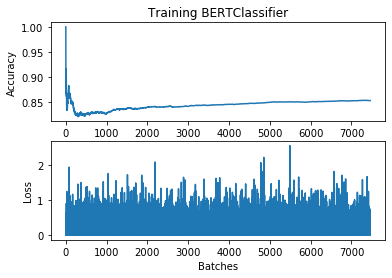

  0%|          | 1/3196 [00:00<09:17,  5.73it/s]

Time for [4 - train model - 1]: 1:57:15.278397


100%|██████████| 3196/3196 [11:37<00:00,  4.58it/s]


Time for [prediction]: 0:11:37.364573
Accuracy in epoch 1: 0.8617703823483386
Confusion Matrix:
[[7923  910]
 [1740 8598]]

Accuracy:  0.86 

Report for [BERTClassifier]:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      8833
           1       0.90      0.83      0.87     10338

    accuracy                           0.86     19171
   macro avg       0.86      0.86      0.86     19171
weighted avg       0.87      0.86      0.86     19171

Time for [6 - evaluate - 1]: 0:11:38.092342


100%|██████████| 44732/44732 [03:47<00:00, 243.43it/s]


Time for [setup training]: 0:03:47.151930
loaded checkpoint for epoch 0
loaded checkpoint for epoch 1
[Epoch 2 Batch 10/7459] loss=0.1006, lr=0.0000050, acc=0.950 - time 0:00:08.855173
[Epoch 2 Batch 20/7459] loss=0.2177, lr=0.0000050, acc=0.925 - time 0:00:09.194471
[Epoch 2 Batch 30/7459] loss=0.2046, lr=0.0000050, acc=0.933 - time 0:00:09.534424
[Epoch 2 Batch 40/7459] loss=0.4577, lr=0.0000050, acc=0.904 - time 0:00:09.422701
[Epoch 2 Batch 50/7459] loss=0.1660, lr=0.0000050, acc=0.906 - time 0:00:08.719641
[Epoch 2 Batch 60/7459] loss=0.2540, lr=0.0000050, acc=0.905 - time 0:00:08.969618
[Epoch 2 Batch 70/7459] loss=0.1567, lr=0.0000050, acc=0.907 - time 0:00:09.282423
[Epoch 2 Batch 80/7459] loss=0.2632, lr=0.0000050, acc=0.900 - time 0:00:09.235231
[Epoch 2 Batch 90/7459] loss=0.0518, lr=0.0000050, acc=0.909 - time 0:00:08.748585
[Epoch 2 Batch 100/7459] loss=0.2015, lr=0.0000050, acc=0.907 - time 0:00:08.991882
[Epoch 2 Batch 110/7459] loss=0.4300, lr=0.0000050, acc=0.904 - tim

[Epoch 2 Batch 980/7459] loss=0.2049, lr=0.0000050, acc=0.880 - time 0:00:08.718344
[Epoch 2 Batch 990/7459] loss=0.1061, lr=0.0000050, acc=0.880 - time 0:00:09.009433
[Epoch 2 Batch 1000/7459] loss=0.2498, lr=0.0000050, acc=0.881 - time 0:00:09.588261
[Epoch 2 Batch 1010/7459] loss=0.3593, lr=0.0000050, acc=0.880 - time 0:00:09.157657
[Epoch 2 Batch 1020/7459] loss=0.2020, lr=0.0000050, acc=0.880 - time 0:00:08.878161
[Epoch 2 Batch 1030/7459] loss=0.1817, lr=0.0000050, acc=0.881 - time 0:00:09.285797
[Epoch 2 Batch 1040/7459] loss=0.4185, lr=0.0000050, acc=0.880 - time 0:00:09.328340
[Epoch 2 Batch 1050/7459] loss=0.0433, lr=0.0000050, acc=0.881 - time 0:00:08.790816
[Epoch 2 Batch 1060/7459] loss=0.3799, lr=0.0000050, acc=0.881 - time 0:00:09.043154
[Epoch 2 Batch 1070/7459] loss=0.1340, lr=0.0000050, acc=0.882 - time 0:00:09.175447
[Epoch 2 Batch 1080/7459] loss=0.1417, lr=0.0000050, acc=0.882 - time 0:00:09.134383
[Epoch 2 Batch 1090/7459] loss=0.1857, lr=0.0000050, acc=0.883 - ti

KeyboardInterrupt: 

In [28]:
for epoch_id in range(5):
    with Timer("4 - train model - {}".format(epoch_id)):
        # stats = train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=epoch_id + 1)
        stats = train(model, data_train, ctx, metric, loss_function, batch_size=6, lr=5e-6, num_epochs=epoch_id + 1)  # seq_len: 512
        plot_train_stats(stats)

    with Timer("6 - evaluate - {}".format(epoch_id)):
        # all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function)
        all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=6)  # seq_len: 512
        print("Accuracy in epoch {}:".format(epoch_id), metric.get()[1])
        y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
        report_training_results(y_true, y_pred, name="BERTClassifier", heatmap=False)

    model.save_parameters("data/bert.model.params")

*may need to use **binary_cross_entrophy**?* (can I use a single label or do I have to use "0" and "1"?)

### Cross topic - Training and evaluating model 

In [40]:
# 1. Getting train and dev data
with Timer("1 - test/train split"):
    X_train, X_dev, y_train, y_dev = get_train_test_sets(cross_traindev_df)

Time for [1 - test/train split]: 0:00:00.023909


In [41]:
# 2. setup
with Timer("2 - setup BERT model"):
    model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert()

BERTModel(
  (encoder): BERTEncoder(
    (dropout_layer): Dropout(p = 0.1, axes=())
    (layer_norm): BERTLayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
    (transformer_cells): HybridSequential(
      (0): BERTEncoderCell(
        (dropout_layer): Dropout(p = 0.1, axes=())
        (attention_cell): MultiHeadAttentionCell(
          (_base_cell): DotProductAttentionCell(
            (_dropout_layer): Dropout(p = 0.1, axes=())
          )
          (proj_query): Dense(768 -> 768, linear)
          (proj_key): Dense(768 -> 768, linear)
          (proj_value): Dense(768 -> 768, linear)
        )
        (proj): Dense(768 -> 768, linear)
        (ffn): BERTPositionwiseFFN(
          (ffn_1): Dense(768 -> 3072, linear)
          (activation): GELU()
          (ffn_2): Dense(3072 -> 768, linear)
          (dropout_layer): Dropout(p = 0.1, axes=())
          (layer_norm): BERTLayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
        )
        (la

In [44]:
with Timer("3 - prepare training data"):
    data_train_raw, data_train = transform_dataset(X_train, y_train, transform)
    print_infos(vocabulary, data_train_raw, data_train)

doctors that perform abortions are often emotionally damaged
unborn life should never depend on whether it is "wanted"
1
vocabulary used for tokenization = 
Vocab(size=30522, unk="[UNK]", reserved="['[PAD]', '[CLS]', '[SEP]', '[MASK]']")
[PAD] token id = 1
[CLS] token id = 2
[SEP] token id = 3
token ids = 
[    2  7435  2008  4685 11324  2015  2024  2411 14868  5591     3  4895
 10280  2166  2323  2196 12530  2006  3251  2009  2003  1000  2359  1000
     3     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     

In [ ]:
with Timer("4 - train model"):
    # train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=3)
    stats = train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=2)
    # model.save_parameters("data/same-side-classification/cross-topic/bert.model.params")
    model.save_parameters("data/bert.model.params")

    plot_train_stats(stats)

In [45]:
with Timer("5 - prepare eval data"):
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
    print_infos(vocabulary, data_dev_raw, data_dev)

alcoholism and drug-use are common after abortions.
uncertainty over whether fetuses are "life" should halt abortions.
1
vocabulary used for tokenization = 
Vocab(size=30522, unk="[UNK]", reserved="['[PAD]', '[CLS]', '[SEP]', '[MASK]']")
[PAD] token id = 1
[CLS] token id = 2
[SEP] token id = 3
token ids = 
[    2 25519  1998  4319  1011  2224  2024  2691  2044 11324  2015  1012
     3 12503  2058  3251 10768  5809  2229  2024  1000  2166  1000  2323
  9190 11324  2015  1012     3     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     

In [ ]:
with Timer("6 - evaluate"):
    # model.load_parameters("data/same-side-classification/cross-topic/bert.model.params", ctx=ctx)
    model.load_parameters("data/bert.model.params", ctx=ctx)
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function)
    print("Accuracy:", metric.get()[1])

    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name="BERTClassifier", heatmap=False)

100%|██████████| 42733/42733 [03:00<00:00, 236.79it/s]


Time for [setup training]: 0:03:00.488541
[Epoch 0 Batch 10/1340] loss=0.7025, lr=0.0000050, acc=0.484 - time 0:00:08.361428
[Epoch 0 Batch 20/1340] loss=0.7088, lr=0.0000050, acc=0.502 - time 0:00:07.863861
[Epoch 0 Batch 30/1340] loss=0.6888, lr=0.0000050, acc=0.511 - time 0:00:07.851966
[Epoch 0 Batch 40/1340] loss=0.7203, lr=0.0000050, acc=0.494 - time 0:00:07.391622
[Epoch 0 Batch 50/1340] loss=0.6932, lr=0.0000050, acc=0.492 - time 0:00:08.379786
[Epoch 0 Batch 60/1340] loss=0.7044, lr=0.0000050, acc=0.492 - time 0:00:08.265135
[Epoch 0 Batch 70/1340] loss=0.7040, lr=0.0000050, acc=0.495 - time 0:00:08.368734
[Epoch 0 Batch 80/1340] loss=0.7151, lr=0.0000050, acc=0.488 - time 0:00:07.782704
[Epoch 0 Batch 90/1340] loss=0.6918, lr=0.0000050, acc=0.492 - time 0:00:07.803205
[Epoch 0 Batch 100/1340] loss=0.6957, lr=0.0000050, acc=0.497 - time 0:00:08.127170
[Epoch 0 Batch 110/1340] loss=0.6970, lr=0.0000050, acc=0.498 - time 0:00:07.942732
[Epoch 0 Batch 120/1340] loss=0.7053, lr=0.

[Epoch 0 Batch 990/1340] loss=0.3575, lr=0.0000050, acc=0.643 - time 0:00:07.525804
[Epoch 0 Batch 1000/1340] loss=0.3347, lr=0.0000050, acc=0.645 - time 0:00:07.836028
[Epoch 0 Batch 1010/1340] loss=0.4355, lr=0.0000050, acc=0.646 - time 0:00:07.923276
[Epoch 0 Batch 1020/1340] loss=0.3516, lr=0.0000050, acc=0.648 - time 0:00:08.059239
[Epoch 0 Batch 1030/1340] loss=0.3880, lr=0.0000050, acc=0.649 - time 0:00:08.442039
[Epoch 0 Batch 1040/1340] loss=0.3875, lr=0.0000050, acc=0.650 - time 0:00:08.250785
[Epoch 0 Batch 1050/1340] loss=0.4257, lr=0.0000050, acc=0.652 - time 0:00:08.270033
[Epoch 0 Batch 1060/1340] loss=0.4278, lr=0.0000050, acc=0.652 - time 0:00:08.211137
[Epoch 0 Batch 1070/1340] loss=0.4119, lr=0.0000050, acc=0.653 - time 0:00:08.053046
[Epoch 0 Batch 1080/1340] loss=0.3934, lr=0.0000050, acc=0.654 - time 0:00:08.373578
[Epoch 0 Batch 1090/1340] loss=0.3717, lr=0.0000050, acc=0.656 - time 0:00:08.250543
[Epoch 0 Batch 1100/1340] loss=0.4026, lr=0.0000050, acc=0.657 - t

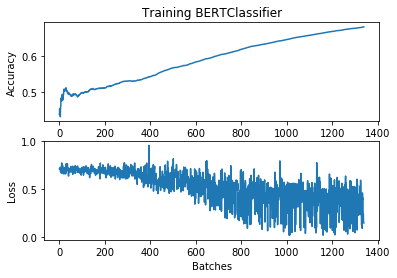

  0%|          | 0/573 [00:00<?, ?it/s]

Time for [4 - train model - 0]: 0:21:00.905422


100%|██████████| 573/573 [02:54<00:00,  4.12it/s]


Time for [prediction]: 0:02:54.762028
Accuracy in epoch 0: 0.7991263991263992
Confusion Matrix:
[[7070 1866]
 [1813 7566]]

Accuracy:  0.8 

Report for [BERTClassifier]:
              precision    recall  f1-score   support

           0       0.80      0.79      0.79      8936
           1       0.80      0.81      0.80      9379

    accuracy                           0.80     18315
   macro avg       0.80      0.80      0.80     18315
weighted avg       0.80      0.80      0.80     18315

Time for [6 - evaluate - 0]: 0:02:55.008217


100%|██████████| 42733/42733 [03:00<00:00, 237.31it/s]


Time for [setup training]: 0:03:00.088994
loaded checkpoint for epoch 0
[Epoch 1 Batch 10/1340] loss=0.3190, lr=0.0000050, acc=0.800 - time 0:00:08.056887
[Epoch 1 Batch 20/1340] loss=0.3110, lr=0.0000050, acc=0.802 - time 0:00:07.907804
[Epoch 1 Batch 30/1340] loss=0.3312, lr=0.0000050, acc=0.810 - time 0:00:08.123907
[Epoch 1 Batch 40/1340] loss=0.3251, lr=0.0000050, acc=0.807 - time 0:00:07.982688
[Epoch 1 Batch 50/1340] loss=0.3924, lr=0.0000050, acc=0.799 - time 0:00:08.426876
[Epoch 1 Batch 60/1340] loss=0.3925, lr=0.0000050, acc=0.794 - time 0:00:08.285148
[Epoch 1 Batch 70/1340] loss=0.3130, lr=0.0000050, acc=0.796 - time 0:00:07.978104
[Epoch 1 Batch 80/1340] loss=0.3142, lr=0.0000050, acc=0.800 - time 0:00:07.831400
[Epoch 1 Batch 90/1340] loss=0.2713, lr=0.0000050, acc=0.807 - time 0:00:07.877264
[Epoch 1 Batch 100/1340] loss=0.3511, lr=0.0000050, acc=0.806 - time 0:00:08.228175
[Epoch 1 Batch 110/1340] loss=0.3976, lr=0.0000050, acc=0.801 - time 0:00:08.138002
[Epoch 1 Batc

[Epoch 1 Batch 980/1340] loss=0.4607, lr=0.0000050, acc=0.820 - time 0:00:08.871616
[Epoch 1 Batch 990/1340] loss=0.3733, lr=0.0000050, acc=0.820 - time 0:00:08.322038
[Epoch 1 Batch 1000/1340] loss=0.3547, lr=0.0000050, acc=0.819 - time 0:00:08.491309
[Epoch 1 Batch 1010/1340] loss=0.2272, lr=0.0000050, acc=0.820 - time 0:00:07.748530
[Epoch 1 Batch 1020/1340] loss=0.3551, lr=0.0000050, acc=0.820 - time 0:00:08.271621
[Epoch 1 Batch 1030/1340] loss=0.3069, lr=0.0000050, acc=0.820 - time 0:00:07.956356
[Epoch 1 Batch 1040/1340] loss=0.2588, lr=0.0000050, acc=0.820 - time 0:00:07.735678
[Epoch 1 Batch 1050/1340] loss=0.1993, lr=0.0000050, acc=0.820 - time 0:00:07.585116
[Epoch 1 Batch 1060/1340] loss=0.2560, lr=0.0000050, acc=0.821 - time 0:00:07.761642
[Epoch 1 Batch 1070/1340] loss=0.4470, lr=0.0000050, acc=0.820 - time 0:00:08.552279
[Epoch 1 Batch 1080/1340] loss=0.2154, lr=0.0000050, acc=0.820 - time 0:00:07.786652
[Epoch 1 Batch 1090/1340] loss=0.3463, lr=0.0000050, acc=0.820 - ti

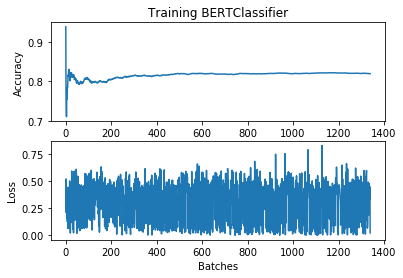

  0%|          | 0/573 [00:00<?, ?it/s]

Time for [4 - train model - 1]: 0:21:01.005022


100%|██████████| 573/573 [02:57<00:00,  3.23it/s]


Time for [prediction]: 0:02:57.432323
Accuracy in epoch 1: 0.8187278187278187
Confusion Matrix:
[[7652 1284]
 [2036 7343]]

Accuracy:  0.82 

Report for [BERTClassifier]:
              precision    recall  f1-score   support

           0       0.79      0.86      0.82      8936
           1       0.85      0.78      0.82      9379

    accuracy                           0.82     18315
   macro avg       0.82      0.82      0.82     18315
weighted avg       0.82      0.82      0.82     18315

Time for [6 - evaluate - 1]: 0:02:57.626244


100%|██████████| 42733/42733 [02:53<00:00, 246.88it/s]


Time for [setup training]: 0:02:53.112406
loaded checkpoint for epoch 0
loaded checkpoint for epoch 1
[Epoch 2 Batch 10/1340] loss=0.2412, lr=0.0000050, acc=0.859 - time 0:00:07.817955
[Epoch 2 Batch 20/1340] loss=0.2040, lr=0.0000050, acc=0.867 - time 0:00:07.625184
[Epoch 2 Batch 30/1340] loss=0.2719, lr=0.0000050, acc=0.865 - time 0:00:07.838813
[Epoch 2 Batch 40/1340] loss=0.3653, lr=0.0000050, acc=0.851 - time 0:00:08.649719
[Epoch 2 Batch 50/1340] loss=0.2842, lr=0.0000050, acc=0.849 - time 0:00:07.830874
[Epoch 2 Batch 60/1340] loss=0.3562, lr=0.0000050, acc=0.837 - time 0:00:08.358638
[Epoch 2 Batch 70/1340] loss=0.2436, lr=0.0000050, acc=0.841 - time 0:00:07.681605
[Epoch 2 Batch 80/1340] loss=0.3478, lr=0.0000050, acc=0.836 - time 0:00:08.520210
[Epoch 2 Batch 90/1340] loss=0.1898, lr=0.0000050, acc=0.843 - time 0:00:07.510132
[Epoch 2 Batch 100/1340] loss=0.3564, lr=0.0000050, acc=0.836 - time 0:00:08.627896
[Epoch 2 Batch 110/1340] loss=0.3529, lr=0.0000050, acc=0.833 - tim

[Epoch 2 Batch 980/1340] loss=0.2240, lr=0.0000050, acc=0.842 - time 0:00:08.165436
[Epoch 2 Batch 990/1340] loss=0.3044, lr=0.0000050, acc=0.842 - time 0:00:08.165068
[Epoch 2 Batch 1000/1340] loss=0.1561, lr=0.0000050, acc=0.843 - time 0:00:07.652056
[Epoch 2 Batch 1010/1340] loss=0.3104, lr=0.0000050, acc=0.843 - time 0:00:08.190643
[Epoch 2 Batch 1020/1340] loss=0.3481, lr=0.0000050, acc=0.842 - time 0:00:08.592282
[Epoch 2 Batch 1030/1340] loss=0.2892, lr=0.0000050, acc=0.842 - time 0:00:08.040040
[Epoch 2 Batch 1040/1340] loss=0.2194, lr=0.0000050, acc=0.842 - time 0:00:07.808520
[Epoch 2 Batch 1050/1340] loss=0.1971, lr=0.0000050, acc=0.843 - time 0:00:07.650845
[Epoch 2 Batch 1060/1340] loss=0.3691, lr=0.0000050, acc=0.842 - time 0:00:08.313384
[Epoch 2 Batch 1070/1340] loss=0.3135, lr=0.0000050, acc=0.842 - time 0:00:08.319475
[Epoch 2 Batch 1080/1340] loss=0.3479, lr=0.0000050, acc=0.842 - time 0:00:08.659965
[Epoch 2 Batch 1090/1340] loss=0.3405, lr=0.0000050, acc=0.841 - ti

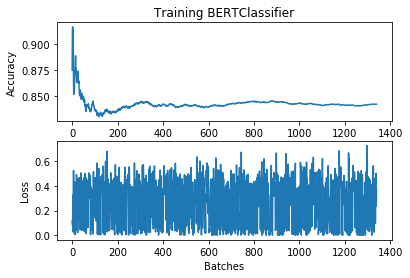

  0%|          | 0/573 [00:00<?, ?it/s]

Time for [4 - train model - 2]: 0:20:56.132282


100%|██████████| 573/573 [02:54<00:00,  3.29it/s]


Time for [prediction]: 0:02:54.209424
Accuracy in epoch 2: 0.8252798252798252
Confusion Matrix:
[[8008  928]
 [2272 7107]]

Accuracy:  0.83 

Report for [BERTClassifier]:
              precision    recall  f1-score   support

           0       0.78      0.90      0.83      8936
           1       0.88      0.76      0.82      9379

    accuracy                           0.83     18315
   macro avg       0.83      0.83      0.82     18315
weighted avg       0.83      0.83      0.82     18315

Time for [6 - evaluate - 2]: 0:02:54.406360


100%|██████████| 42733/42733 [02:55<00:00, 243.17it/s]


Time for [setup training]: 0:02:55.751295
loaded checkpoint for epoch 0
loaded checkpoint for epoch 1
loaded checkpoint for epoch 2
[Epoch 3 Batch 10/1340] loss=0.2473, lr=0.0000050, acc=0.884 - time 0:00:08.029340
[Epoch 3 Batch 20/1340] loss=0.2455, lr=0.0000050, acc=0.870 - time 0:00:07.872185
[Epoch 3 Batch 30/1340] loss=0.2390, lr=0.0000050, acc=0.872 - time 0:00:07.859373
[Epoch 3 Batch 40/1340] loss=0.2375, lr=0.0000050, acc=0.870 - time 0:00:07.893533
[Epoch 3 Batch 50/1340] loss=0.3373, lr=0.0000050, acc=0.861 - time 0:00:08.711087
[Epoch 3 Batch 60/1340] loss=0.0932, lr=0.0000050, acc=0.876 - time 0:00:07.244797
[Epoch 3 Batch 70/1340] loss=0.3387, lr=0.0000050, acc=0.867 - time 0:00:08.466650
[Epoch 3 Batch 80/1340] loss=0.3627, lr=0.0000050, acc=0.858 - time 0:00:08.566466
[Epoch 3 Batch 90/1340] loss=0.3102, lr=0.0000050, acc=0.853 - time 0:00:08.307661
[Epoch 3 Batch 100/1340] loss=0.2763, lr=0.0000050, acc=0.853 - time 0:00:08.054355
[Epoch 3 Batch 110/1340] loss=0.2948,

[Epoch 3 Batch 980/1340] loss=0.2894, lr=0.0000050, acc=0.869 - time 0:00:08.244752
[Epoch 3 Batch 990/1340] loss=0.3009, lr=0.0000050, acc=0.869 - time 0:00:08.227153
[Epoch 3 Batch 1000/1340] loss=0.2880, lr=0.0000050, acc=0.868 - time 0:00:08.239553
[Epoch 3 Batch 1010/1340] loss=0.2211, lr=0.0000050, acc=0.869 - time 0:00:08.125446
[Epoch 3 Batch 1020/1340] loss=0.2032, lr=0.0000050, acc=0.869 - time 0:00:07.937979
[Epoch 3 Batch 1030/1340] loss=0.3282, lr=0.0000050, acc=0.868 - time 0:00:08.073664
[Epoch 3 Batch 1040/1340] loss=0.2977, lr=0.0000050, acc=0.868 - time 0:00:08.296232
[Epoch 3 Batch 1050/1340] loss=0.3021, lr=0.0000050, acc=0.868 - time 0:00:08.249256
[Epoch 3 Batch 1060/1340] loss=0.2971, lr=0.0000050, acc=0.868 - time 0:00:08.405073
[Epoch 3 Batch 1070/1340] loss=0.1828, lr=0.0000050, acc=0.868 - time 0:00:07.701351
[Epoch 3 Batch 1080/1340] loss=0.2723, lr=0.0000050, acc=0.868 - time 0:00:08.210484
[Epoch 3 Batch 1090/1340] loss=0.1998, lr=0.0000050, acc=0.868 - ti

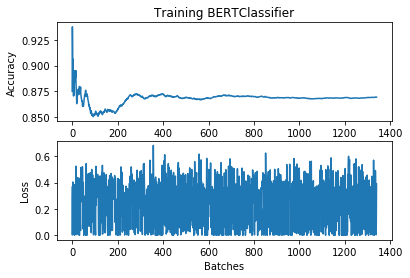

  0%|          | 0/573 [00:00<?, ?it/s]

Time for [4 - train model - 3]: 0:20:56.171990


100%|██████████| 573/573 [02:48<00:00,  3.41it/s]


Time for [prediction]: 0:02:48.229060
Accuracy in epoch 3: 0.8398034398034399
Confusion Matrix:
[[7905 1031]
 [1903 7476]]

Accuracy:  0.84 

Report for [BERTClassifier]:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      8936
           1       0.88      0.80      0.84      9379

    accuracy                           0.84     18315
   macro avg       0.84      0.84      0.84     18315
weighted avg       0.84      0.84      0.84     18315

Time for [6 - evaluate - 3]: 0:02:48.447808


100%|██████████| 42733/42733 [02:53<00:00, 246.99it/s]


Time for [setup training]: 0:02:53.033514
loaded checkpoint for epoch 0
loaded checkpoint for epoch 1
loaded checkpoint for epoch 2
loaded checkpoint for epoch 3
[Epoch 4 Batch 10/1340] loss=0.2879, lr=0.0000050, acc=0.856 - time 0:00:08.819047
[Epoch 4 Batch 20/1340] loss=0.3237, lr=0.0000050, acc=0.838 - time 0:00:08.510386
[Epoch 4 Batch 30/1340] loss=0.1372, lr=0.0000050, acc=0.869 - time 0:00:07.445968
[Epoch 4 Batch 40/1340] loss=0.1921, lr=0.0000050, acc=0.879 - time 0:00:08.055229
[Epoch 4 Batch 50/1340] loss=0.1141, lr=0.0000050, acc=0.894 - time 0:00:07.778778
[Epoch 4 Batch 60/1340] loss=0.2939, lr=0.0000050, acc=0.887 - time 0:00:07.995121
[Epoch 4 Batch 70/1340] loss=0.2473, lr=0.0000050, acc=0.885 - time 0:00:07.895962
[Epoch 4 Batch 80/1340] loss=0.1911, lr=0.0000050, acc=0.886 - time 0:00:07.983766
[Epoch 4 Batch 90/1340] loss=0.2203, lr=0.0000050, acc=0.887 - time 0:00:08.456483
[Epoch 4 Batch 100/1340] loss=0.2791, lr=0.0000050, acc=0.885 - time 0:00:08.371531
[Epoch 

[Epoch 4 Batch 970/1340] loss=0.2269, lr=0.0000050, acc=0.892 - time 0:00:08.059267
[Epoch 4 Batch 980/1340] loss=0.2893, lr=0.0000050, acc=0.891 - time 0:00:08.431667
[Epoch 4 Batch 990/1340] loss=0.0970, lr=0.0000050, acc=0.892 - time 0:00:07.226958
[Epoch 4 Batch 1000/1340] loss=0.1872, lr=0.0000050, acc=0.892 - time 0:00:07.658970
[Epoch 4 Batch 1010/1340] loss=0.1682, lr=0.0000050, acc=0.892 - time 0:00:08.107551
[Epoch 4 Batch 1020/1340] loss=0.2266, lr=0.0000050, acc=0.893 - time 0:00:07.991096
[Epoch 4 Batch 1030/1340] loss=0.1403, lr=0.0000050, acc=0.893 - time 0:00:07.313752
[Epoch 4 Batch 1040/1340] loss=0.1839, lr=0.0000050, acc=0.893 - time 0:00:07.977764
[Epoch 4 Batch 1050/1340] loss=0.1698, lr=0.0000050, acc=0.893 - time 0:00:07.706508
[Epoch 4 Batch 1060/1340] loss=0.2510, lr=0.0000050, acc=0.893 - time 0:00:07.642596
[Epoch 4 Batch 1070/1340] loss=0.2044, lr=0.0000050, acc=0.893 - time 0:00:08.102700
[Epoch 4 Batch 1080/1340] loss=0.2161, lr=0.0000050, acc=0.893 - tim

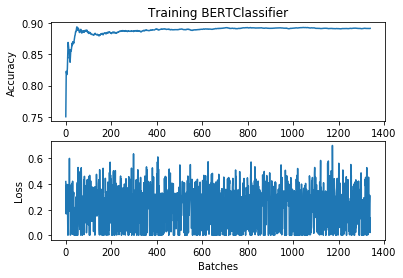

  0%|          | 0/573 [00:00<?, ?it/s]

Time for [4 - train model - 4]: 0:20:54.438874


100%|██████████| 573/573 [02:50<00:00,  3.36it/s]


Time for [prediction]: 0:02:50.732861
Accuracy in epoch 4: 0.8485940485940486
Confusion Matrix:
[[7708 1228]
 [1545 7834]]

Accuracy:  0.85 

Report for [BERTClassifier]:
              precision    recall  f1-score   support

           0       0.83      0.86      0.85      8936
           1       0.86      0.84      0.85      9379

    accuracy                           0.85     18315
   macro avg       0.85      0.85      0.85     18315
weighted avg       0.85      0.85      0.85     18315

Time for [6 - evaluate - 4]: 0:02:50.930598


In [46]:
for epoch_id in range(5):
    with Timer("4 - train model - {}".format(epoch_id)):
        stats = train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=epoch_id + 1)
        plot_train_stats(stats)

    with Timer("6 - evaluate - {}".format(epoch_id)):
        all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function)
        print("Accuracy in epoch {}:".format(epoch_id), metric.get()[1])
        y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
        report_training_results(y_true, y_pred, name="BERTClassifier", heatmap=False)

    model.save_parameters("data/bert.model.params")